In [1]:
import scanpy as sc
import visium_stitcher as vs

Stitching together Visium samples is a two-step process. The first step is aligning the `hires` images from the spaceranger output of your individual slides in Fiji. Perform the following:

1. Open new project by clicking on File --> New --> TrakEM (blank)
2. Select folder containing hires Visium images found in the `spatial` output folder of spaceranger
3. Right click on black canvas in Fiji and select Import. The selected folder will open and you can import the two images you want to stitch
4. If the images don't fit the canvas, you can scale them down by selecting each image and then click on Image --> Scale --> modify values of scale in X and scale in Y to the desired fraction (e.g. 0.8)
5. Once the two images are of the desired size, select them both and right click to select Adjust images --> Blend (selected images) 
6. Select the image that you want to rotate and move around and right click to select Transform --> Transform (affine)
7. Rotate and move around the image as you wish and overlay it with the other image to obtain the desired combined image. Then right click to select Apply transform
8. Save as `.xml` by clicking File --> Save (.xml format is the default saving method)

Once armed in the `.xml` file produced by Fiji, along with one folder per sample holding the `filtered_feature_bc_matrix.h5` and `spatial` outputs of spaceranger, you can create a joint object.

Start off by loading the transforms and inspecting them. By default, `vs.transform_finder()` will return a dictionary of the image paths used during the Fiji step, along with the corresponding transform. Take note of the image paths and their correspondence to spaceranger output that will be loaded shortly.

In [2]:
transforms = vs.transform_finder("rawdata/18_19.xml")
transforms

{'18_tissue_hires_image.png': array([[6.3000e-01, 0.0000e+00, 7.7573e+02],
        [0.0000e+00, 6.3000e-01, 8.0633e+02]]),
 '19_tissue_hires_image.png': array([[-6.16423717e-01, -1.30083825e-01,  1.72435503e+03],
        [ 1.30083825e-01, -6.16423717e-01,  1.44201338e+03]])}

Load the spaceranger outputs for the two samples, and ensure the objects are concatenation-ready by storing the sample information (both in the `.obs_names` and an `.obs` column) and making the variable names unique.

Our `18_tissue_hires_image.png` Fiji image path transform from earlier corresponds to sample `HCA_F_RepTsp13447718`, and `19_tissue_hires_image.png` corresponds to `HCA_F_RepTsp13447719`. Extract the transforms from the dictionary and store them in `.uns['transform']`, which is where `vs.stitcher()` needs them stored.

In [3]:
adata1 = sc.read_visium("rawdata/HCA_F_RepTsp13447718")
adata1.var_names_make_unique()
adata1.obs_names = ["HCA_F_RepTsp13447718-"+i for i in adata1.obs_names]
adata1.obs['sample'] = "HCA_F_RepTsp13447718"
adata1.uns['transform'] = transforms["18_tissue_hires_image.png"]

adata2 = sc.read_visium("rawdata/HCA_F_RepTsp13447719")
adata2.var_names_make_unique()
adata2.obs_names = ["HCA_F_RepTsp13447719-"+i for i in adata2.obs_names]
adata2.obs['sample'] = "HCA_F_RepTsp13447719"
adata2.uns['transform'] = transforms["19_tissue_hires_image.png"]

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


At this point we can perform the stitching. The object order matters, as it will dictate the priority in taking spots in the event of an overlap, as well as the order of the images when recreating a joint image based on the transforms.

In [4]:
adata = vs.stitch([adata1, adata2])

`adata` is a functional Visium object storing both our samples, with the images and spots transformed accordingly to create a single joint entity.

... storing 'sample' as categorical


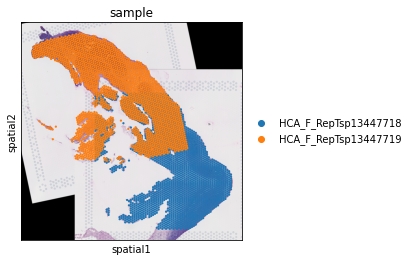

In [5]:
sc.pl.spatial(adata, color="sample")

Overlapping spots can be removed based on `.obs['overlap']`, giving priority to spots based on the order the objects were passed in to `vs.stitch()`.

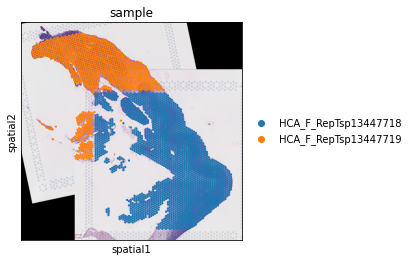

In [6]:
adata_nooverlap = adata[~adata.obs["overlap"]]
sc.pl.spatial(adata_nooverlap, color="sample")